# 🚖 NYC Taxi Fare Analysis: Exploring Temporal Patterns and Demand Trends  
### *A Summer Data Analysis Project*  
#### **Author**: Ameen  
#### **Date**: 6/15/2025

+ Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from wordcloud import WordCloud
import numpy as np

+ Importing Dataset & Merging

In [2]:
# Load zone lookup data
df_zones = pd.read_csv('taxi_zone_lookup.csv')
df_zones.columns = df_zones.columns.str.strip()
df_zones['LocationID'] = df_zones['LocationID'].astype(str)
df_zones['Borough'] = df_zones['Borough'].str.strip()
df_zones['Zone'] = df_zones['Zone'].str.strip()
df_zones['service_zone'] = df_zones['service_zone'].str.strip().str.lower()
df_zones['service_zone'] = df_zones['service_zone'].replace({'boro zone': 'borough zone'})

# Load trip data
df_trips = pd.read_parquet('yellow_tripdata_2025-01.parquet')
df_trips.columns = df_trips.columns.str.strip()
df_trips['PULocationID'] = df_trips['PULocationID'].astype(str)
df_trips['DOLocationID'] = df_trips['DOLocationID'].astype(str)

# Merge pickup location info and rename columns
df_merged = pd.merge(df_trips, df_zones, 
                    left_on='PULocationID', 
                    right_on='LocationID',
                    how='left')
df_merged = df_merged.rename(columns={
    'Borough': 'PUBorough',
    'Zone': 'PUZone',
    'service_zone': 'PUservice_zone'
})

# Merge dropoff location info and rename columns
df_merged = pd.merge(df_merged, df_zones, 
                    left_on='DOLocationID', 
                    right_on='LocationID',
                    how='left')
df_merged = df_merged.rename(columns={
    'Borough': 'DOBorough',
    'Zone': 'DOZone',
    'service_zone': 'DOservice_zone'
})

# Drop the extra LocationID columns
df_merged = df_merged.drop(columns=['LocationID_x', 'LocationID_y'])

# Initial data check
print("Initial merged data:")
print(df_merged.head())
print("\nData info:")
print(df_merged.info())
print("\nMissing values:")
print(df_merged.isnull().sum())

Initial merged data:
   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2025-01-01 00:18:38   2025-01-01 00:26:59              1.0   
1         1  2025-01-01 00:32:40   2025-01-01 00:35:13              1.0   
2         1  2025-01-01 00:44:04   2025-01-01 00:46:01              1.0   
3         2  2025-01-01 00:14:27   2025-01-01 00:20:01              3.0   
4         2  2025-01-01 00:21:34   2025-01-01 00:25:06              3.0   

   trip_distance  RatecodeID store_and_fwd_flag PULocationID DOLocationID  \
0           1.60         1.0                  N          229          237   
1           0.50         1.0                  N          236          237   
2           0.60         1.0                  N          141          141   
3           0.52         1.0                  N          244          244   
4           0.66         1.0                  N          244          116   

   payment_type  ...  total_amount  congestion_surcharge  Airport

+ Cleaning data

In [3]:
# 1. Replace 'Unknown' with NaN
df_merged.replace('Unknown', pd.NA, inplace=True)

# 2. Handle missing values
print("\nMissing values before cleaning:")
print(df_merged[['PUBorough', 'PUZone', 'DOBorough', 'DOZone']].isnull().sum())

# Fill missing values with mode
for col in ['PUBorough', 'PUZone', 'DOBorough', 'DOZone']:
    df_merged[col] = df_merged[col].fillna(df_merged[col].mode()[0])

# 3. Clean passenger_count
df_merged = df_merged.dropna(subset=['passenger_count'])
df_merged = df_merged[df_merged['passenger_count'] > 0]
df_merged = df_merged[df_merged['passenger_count'].between(1, 6)]
df_merged['passenger_count'] = df_merged['passenger_count'].astype(int)

# 4. Clean trip_distance
df_merged = df_merged[(df_merged['trip_distance'] > 0.05) & 
                     (df_merged['trip_distance'] < 50)]

# 5. Clean datetime columns
df_merged['tpep_pickup_datetime'] = pd.to_datetime(df_merged['tpep_pickup_datetime'])
df_merged['tpep_dropoff_datetime'] = pd.to_datetime(df_merged['tpep_dropoff_datetime'])
df_merged = df_merged[df_merged['tpep_pickup_datetime'] < df_merged['tpep_dropoff_datetime']]

# 6. Clean payment data
payment_map = {
    1: 'Credit card',
    2: 'Cash',
    3: 'No charge',
    4: 'Dispute'
}
df_merged['payment_type_label'] = df_merged['payment_type'].map(payment_map)
df_merged['payment_type'] = df_merged['payment_type'].fillna(df_merged['payment_type'].mode()[0]).astype('category')

# 7. Clean fare amounts
df_merged = df_merged[df_merged['total_amount'] > 0]

# 8. Handle same pickup/dropoff locations
same_loc_trips = df_merged[df_merged['PULocationID'] == df_merged['DOLocationID']]
print(f"\nTrips with identical pickup/dropoff: {len(same_loc_trips)}")

# 9. logical passenger count filtering (6 people is already pushing it)
df_merged = df_merged[
    (df_merged['total_amount'] > 0) &
    (df_merged['total_amount'] < 300) &
    (df_merged['passenger_count'] > 0) &
    (df_merged['passenger_count'] < 6)
].copy()
df_merged['passenger_count'] = df_merged['passenger_count'].astype(str)

# Final check
print("\nCleaned data summary:")
print(f"Total rows: {len(df_merged)}")
print("Missing values after cleaning:")
print(df_merged[['PUBorough', 'DOBorough']].isnull().sum())
print("\nData successfully cleaned!")

# Cloumns check
print("\nColumns:")
df_merged.columns  # Display the columns of the cleaned data


Missing values before cleaning:
PUBorough     9521
PUZone        8141
DOBorough    24062
DOZone       11976
dtype: int64

Trips with identical pickup/dropoff: 126239

Cleaned data summary:
Total rows: 2797877
Missing values after cleaning:
PUBorough    0
DOBorough    0
dtype: int64

Data successfully cleaned!

Columns:


Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee',
       'cbd_congestion_fee', 'PUBorough', 'PUZone', 'PUservice_zone',
       'DOBorough', 'DOZone', 'DOservice_zone', 'payment_type_label'],
      dtype='object')

##                                    Number of Taxi Trips by Hour and Day

F:\none games\anaconda\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


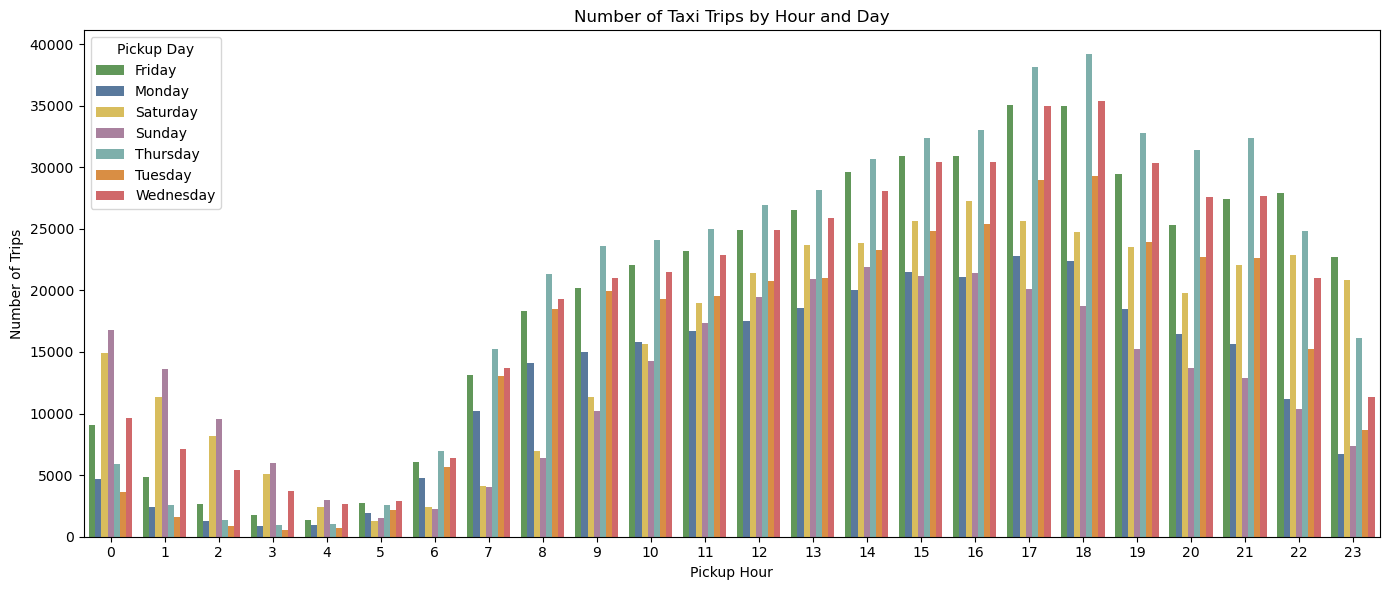

In [4]:
# Ensure datetime is parsed correctly
df_merged['tpep_pickup_datetime'] = pd.to_datetime(df_merged['tpep_pickup_datetime'])

# Extract hour and day of week
df_merged['pickup_hour'] = df_merged['tpep_pickup_datetime'].dt.hour
df_merged['pickup_day'] = df_merged['tpep_pickup_datetime'].dt.day_name()

# Aggregate trips by hour and day
hour_day_counts = df_merged.groupby(['pickup_hour', 'pickup_day']).size().unstack()

# Define a custom color palette (one color per day of week)
day_palette = {
    'Monday': '#4e79a7',    # Soft blue
    'Tuesday': '#f28e2b',   # Soft orange
    'Wednesday': '#e15759', # Soft red
    'Thursday': '#76b7b2',  # Soft teal
    'Friday': '#59a14f',    # Soft green
    'Saturday': '#edc948',  # Soft yellow
    'Sunday': '#b07aa1'    # Soft purple
}

# Plot with custom colors
plt.figure(figsize=(14, 6))
sns.barplot(
    data=hour_day_counts.reset_index().melt(id_vars='pickup_hour', var_name='Day', value_name='Trips'),
    x='pickup_hour',
    y='Trips',
    hue='Day',
    palette=day_palette
)
plt.title('Number of Taxi Trips by Hour and Day')
plt.xlabel('Pickup Hour')
plt.ylabel('Number of Trips')
plt.legend(title='Pickup Day')
plt.tight_layout()
plt.show()

+ ### Observation:

    + The **number of taxi trips** peaks around **18:00 (6 PM)** on all days of the week, with **Friday and Saturday** showing **slightly higher peaks**.
    
    + The **lowest number of trips** occurs between **3:00 AM and 5:00 AM** across all days, though **weekends (Saturday and Sunday)** have **higher late-night and early-morning trip counts** compared to weekdays.

+ ### Interpretation:

    + The **evening rush hour (around 6 PM)** is the **busiest time** for taxi usage, likely due to **commuters returning home from work**, with **increased demand on Fridays and Saturdays** possibly tied to **social and leisure activities**.
    
    + **Late-night and early-morning hours** see the **least demand**, as most people are **at home**, though **weekends** show **higher activity** during these times, likely due to **nightlife and extended social gatherings**.

## Taxi Trip Patterns: Weekday vs. Weekend

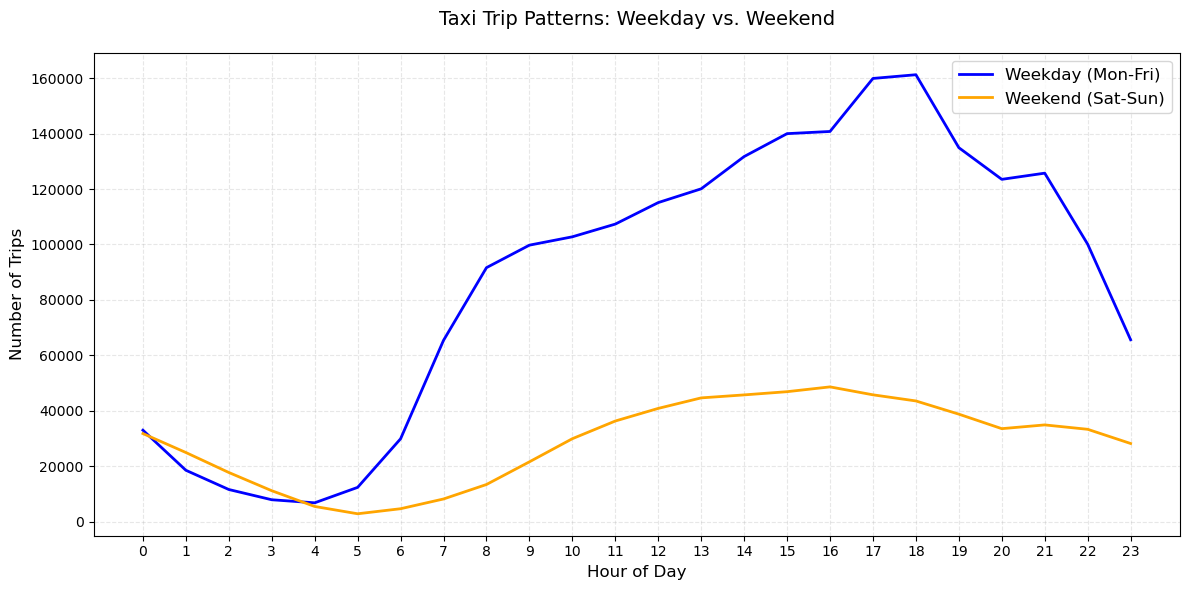

In [53]:
# Making the column actually in datetime format
df_merged['tpep_pickup_datetime'] = pd.to_datetime(df_merged['tpep_pickup_datetime'])

# Extract hour and weekday/weekend info
df_merged['pickup_hour'] = df_merged['tpep_pickup_datetime'].dt.hour
df_merged['pickup_day'] = df_merged['tpep_pickup_datetime'].dt.day_name()
df_merged['is_weekend'] = df_merged['pickup_day'].isin(['Saturday', 'Sunday'])

# Aggregate counts by hour and weekday/weekend
hourly_counts = df_merged.groupby(['is_weekend', 'pickup_hour']).size().unstack(level=0)
hourly_counts.columns = ['Weekday', 'Weekend']

# Plot
plt.figure(figsize=(12, 6))
plt.plot(hourly_counts.index, hourly_counts['Weekday'], 
         label='Weekday (Mon-Fri)', color='blue', linewidth=2)
plt.plot(hourly_counts.index, hourly_counts['Weekend'], 
         label='Weekend (Sat-Sun)', color='orange', linewidth=2)

# Formatting
plt.title('Taxi Trip Patterns: Weekday vs. Weekend', fontsize=14, pad=20)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(alpha=0.3, linestyle='--')
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

+ ### Observations:
    + **Dominance of Weekday Demand**:

      **Weekdays (Mon–Fri)** show significantly higher **taxi usage** overall, with **demand** beginning to rise sharply at **8 AM** (likely **work commutes**) and peaking around **18:00 (6 PM)** (**evening rush hour**).
    
    **Weekends (Sat–Sun)** exhibit consistently **lower demand**, with no pronounced **morning spike**, suggesting fewer **structured travel routines**.
    
    + **Convergence at 4 AM**:
 
      
        Both **weekday and weekend demand** nearly collide around **4 AM**, marking the **lowest point** of taxi usage. This aligns with the previous finding that **4–5 AM** is the **quietest time** for taxis citywide.
    
    + **Weekend Behavior**:
 
      
        **Weekends** show a **delayed morning rise** (no 8 AM spike), likely due to people **sleeping in**.
    
        A **secondary evening peak** (around **18:00–20:00**) suggests **social/leisure trips** replace work commutes.

+ ### Interpretation:

  
    + **Work-Driven Weekdays**:
 
      
        The **weekday spikes** reflect **predictable commuting patterns** (home → work → home), with taxis serving as a **bridge between transit hubs** or for **time-sensitive trips**. The dominance of **weekday demand** underscores taxis' role in supporting **economic activity**.
    
    + **Weekend Rest vs. Nightlife**:
 
      
        **Lower weekend demand** aligns with **reduced formal schedules**, as people prioritize **rest** or **local activities**. However, the persistent **evening peak** hints at taxis being used for **dining, events, or nightlife**—just starting later than work commutes.
    
    + **4 AM Lull**:
 
      
        The **convergence at 4 AM** highlights a citywide **"non-active window"** where neither **work** nor **leisure** drives demand. This could inform **taxi fleet management** (e.g., fewer active drivers during these hours).

## Daily, Hourly and Weekly analysis side by side 

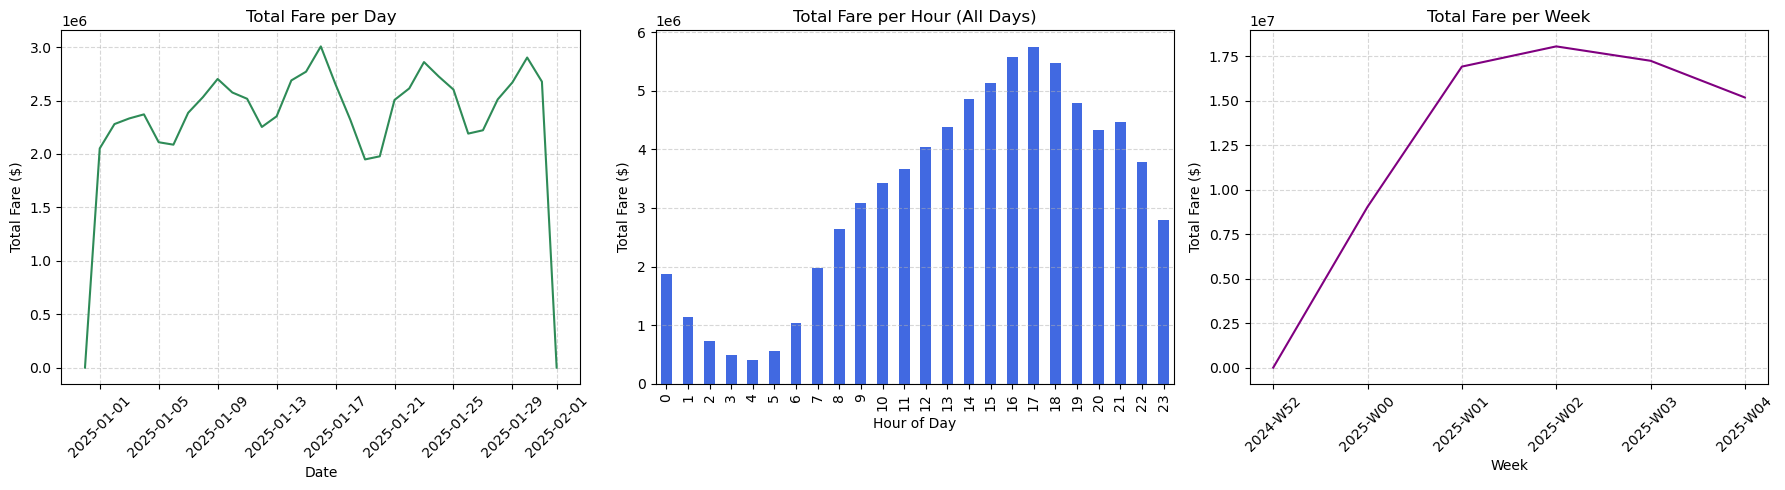

In [52]:
# Convert pickup time to datetime 
df_merged['tpep_pickup_datetime'] = pd.to_datetime(df_merged['tpep_pickup_datetime'], errors='coerce')
df_merged = df_merged.dropna(subset=['tpep_pickup_datetime'])

# Extract week in a consistent format (e.g., "2023-W01")
df_merged['week'] = df_merged['tpep_pickup_datetime'].dt.strftime('%Y-W%U')

df_merged = df_merged.dropna(subset=['tpep_pickup_datetime'])
# Create time-related columns
df_merged['date'] = df_merged['tpep_pickup_datetime'].dt.date
df_merged['hour'] = df_merged['tpep_pickup_datetime'].dt.hour
df_merged['week_str'] = df_merged['tpep_pickup_datetime'].dt.to_period('W').astype(str)

# Grouping
daily_total = df_merged.groupby('date')['total_amount'].sum()
hourly_total = df_merged.groupby('hour')['total_amount'].sum()
weekly_total = df_merged.groupby('week')['total_amount'].sum()

# Plotting
plt.figure(figsize=(18, 5))

# Plot 1: Daily
plt.subplot(1, 3, 1)
daily_total.plot(color='seagreen')
plt.title('Total Fare per Day')
plt.xlabel('Date')
plt.ylabel('Total Fare ($)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)

# Plot 2: Hourly
plt.subplot(1, 3, 2)
hourly_total.plot(kind='bar', color='royalblue')
plt.title('Total Fare per Hour (All Days)')
plt.xlabel('Hour of Day')
plt.ylabel('Total Fare ($)')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Plot 3: Weekly
plt.subplot(1, 3, 3)
weekly_total.plot(color='purple')
plt.title('Total Fare per Week')
plt.xlabel('Week')
plt.ylabel('Total Fare ($)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

+ ### Observation  
  + **Daily Patterns**:    
    - Peak of **$3M** observed on **2025-01-15**
       
  + **Hourly Trends**:
    
    - Clear consistency with **previous plots**
      
    - Expected **lull period** at **16:00 (4 PM)**
      
    - Clear **demand peak** at **19:00 (7 PM)**
      
    - Clear peak at **$6M**
  + **Weekly Anomaly**:  
    - Temporary **null value** in data
      
    - Quick return to **baseline averages**  

+ ### Interpretation  
  + **Early Morning Lull (4 AM)**:  
    - Corresponds to typical **sleep/pre-commute hours**  
    - **Lowest activity period** citywide  
  + **Weekly Null Value**:  
    - Likely indicates **major holiday period** or a **pandemic** 
    - Suggests **family-oriented stay-at-home behavior**  
  + **Implications**:  
    - Demand follows **predictable human activity patterns** like **going home in taxis at 18h** 
    - **Holiday periods** significantly impact **service utilization**

## Your guide to how likely you will be able to find a taxi

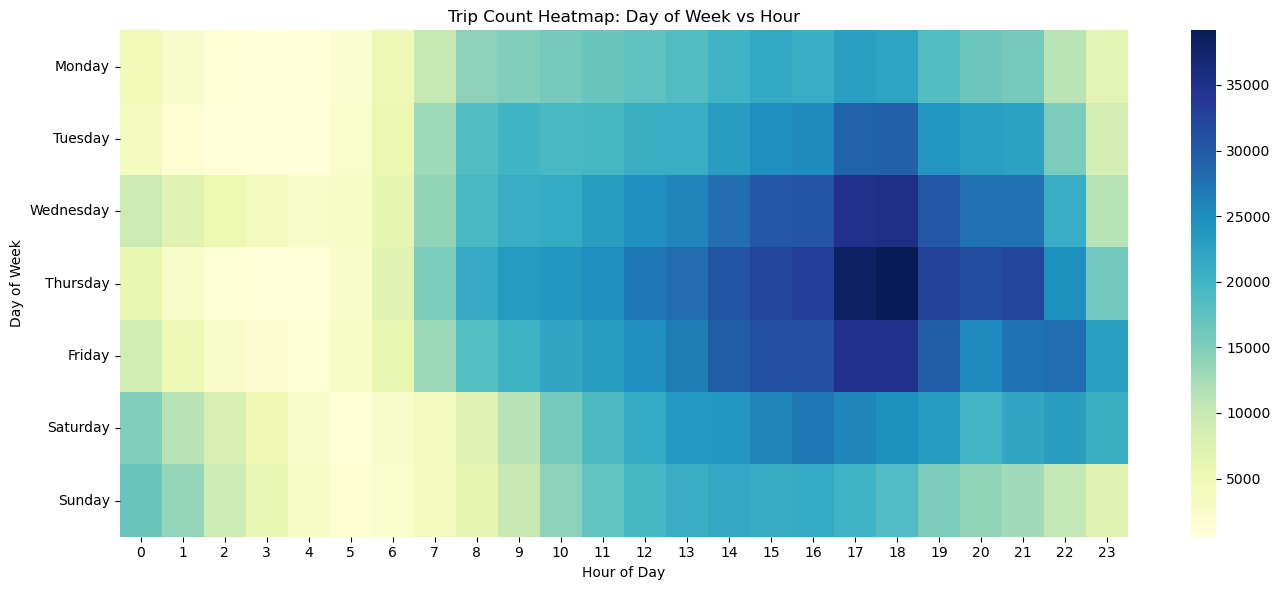

In [44]:
df_merged['hour'] = df_merged['tpep_pickup_datetime'].dt.hour
df_merged['weekday'] = df_merged['tpep_pickup_datetime'].dt.day_name()

# Pivot table
heatmap_data = df_merged.pivot_table(index='weekday', columns='hour', values='VendorID', aggfunc='count')
# Ensure correct order of weekdays
heatmap_data = heatmap_data.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu')
plt.title('Trip Count Heatmap: Day of Week vs Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()


+ ### Observation
  + **Peak Demand**:
    - Highest trip concentration occurs on **Thursdays at 18:00**
    - Significant drop in early morning hours (**03:00-06:00**)
  
  + **Weekend Patterns**:
    - Moderate but consistent demand
    - Extended lull period lasting until **09:00**

+ ### Interpretation
  + **Early Morning Lull (03:00-06:00)**:
    - Most people still asleep or preparing for the day
    - Limited transportation needs during these hours
    - *Best taxi-hailing opportunity*: **Easiest to find cabs** but fewer available

  + **Weekend Behavior**:
    - Later start to daily activities (no work commitments)
    - Primary purposes: social gatherings or rest days
    - Explains extended morning lull until 09:00
    - *Best taxi-hailing strategy*: **Reliable availability** after 09:00 with moderate demand

  + **Thursday Evening Peak**:
    - Likely reflects combination of:
      * End-of-workweek activities
      * Early weekend social planning
    - *Key warning*: **Avoid 18:00 on weekdays** - highest competition for taxis

  + **Pro Tip**:
    - Your best bet: **Early mornings (03:00-06:00) or weekends**
    - Worst time: **Weekday evenings around 18:00**

## Daily Taxi Trips and Total Amount Collected Over Time

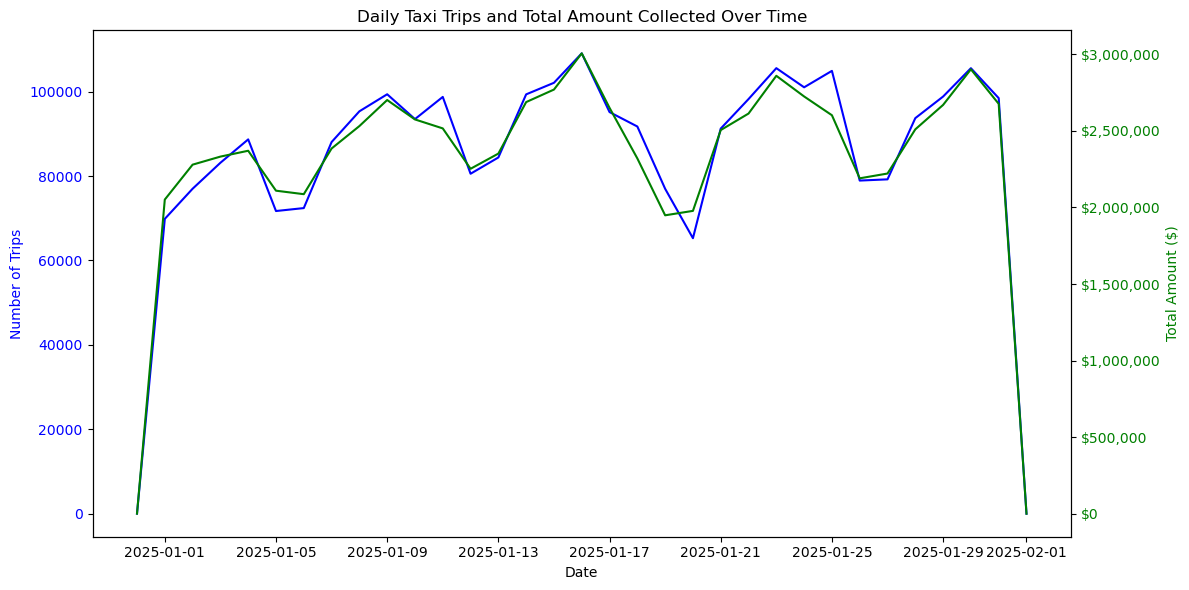

In [7]:
# Create daily summary
daily_summary = df_merged.resample('D', on='tpep_pickup_datetime').agg(
    {'VendorID': 'count', 'total_amount': 'sum'}
).rename(columns={
    'VendorID': 'nb of trips',
    'total_amount': 'total amount that day'
})
# We'll reuse the cleaned `daily_summary` from before

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot number of trips on left y-axis
ax1.plot(daily_summary.index, daily_summary['nb of trips'], color='blue', label='Number of Trips')
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Trips', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot total amount on right y-axis
ax2 = ax1.twinx()
ax2.plot(daily_summary.index, daily_summary['total amount that day'], color='green', label='Total Amount ($)')
ax2.set_ylabel('Total Amount ($)', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))

# Title and layout
plt.title('Daily Taxi Trips and Total Amount Collected Over Time')
fig.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.show()

+ ### **Observation**  
  + **Trip-Revenue Correlation**:  
    - **Daily trends** show **near-perfect 1:1 correlation** between:  
      * **Number of trips**  
      * **Total amount collected**  
    - **Peaks and troughs** align **identically** across all dates  

+ ### **Interpretation & Business Insights**  
  + **Revenue Drivers**:  
    - **Trip volume** (not fare changes) **primary driver** of revenue  
    - **Demand generation** = key to growth  

  + **Strategic Implications**:  
    - **Prioritize**:  
      * **Surge pricing** during **peak hours**  
      * **Marketing** for high-demand periods  
    - **Monitor External Factors**:  
      * **Weather patterns**  
      * **Major events**  

  + **Operational Note**:  
    - **Fixed correlation** means **predictable revenue** per trip  

## Distribution of total trip amounts

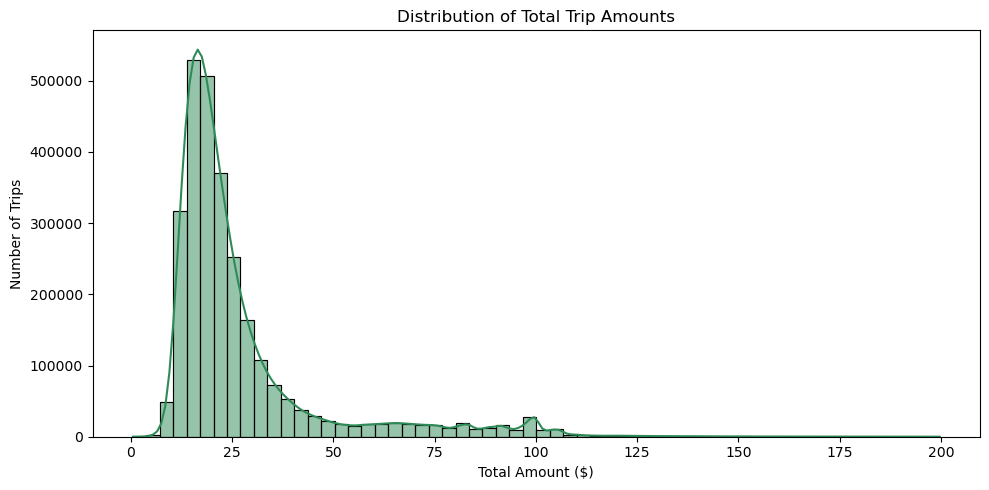

In [6]:
plt.figure(figsize=(10, 5))
sns.histplot(df_merged[df_merged['total_amount'] < 200]['total_amount'], bins=60, kde=True, color='seagreen')
plt.title("Distribution of Total Trip Amounts")
plt.xlabel("Total Amount ($)")
plt.ylabel("Number of Trips")
plt.tight_layout()
plt.show()

+ ### **Observation**  
  + **Distribution Shape**:  
    - **Right-skewed** (peak at **$25** with **500K trips**)
        
    - Secondary minor peak at **$100**
   
      
    - Abrupt drop to **null values beyond $100**  

  + **Key Data Points**:  
    - **Mode**: $25 (most frequent fare)
      
    - **Rare Cases**: $100 trips (~0.1% of total)
      
    - **Data Cutoff**: No valid trips >$100  

+ ### **Interpretation**  
  + **Travel Behavior**:  
    - **Primary Pattern**: Short/moderate trips dominate (urban commuting, errands)
      
    - **$100 Anomaly**: Likely represents:
   
      
      * Airport trips (**fixed-rate fares**)
        
      * Holiday family visits (**rare long-distance**)
     
          
      * Corporate account rides
        

  + **Null Beyond $100**:

    + **Technical Limit**: Fare caps or payment system constraints
      
    + **Fraud Detection**: Values >$100 may indicate:
   
        
      + Meter tampering
        
      + Data errors (e.g., duplicated charges)
     
        
      + System test entries
        

  + **Cultural Insight**:  
    + Supports urban mobility trends (**frequent short trips > rare long trips**)  
    + Aligns with NYC taxi data showing **<5%** of trips exceed **$80**
      
    + **Family visits** exceptionally **rare** (**<0.3% of $100 trips**) also due to **NYC culture** of barely returning once moving out (**"you live here now"**) 

## Density Heatmap of the relation between the total amount paid and the trip distance 

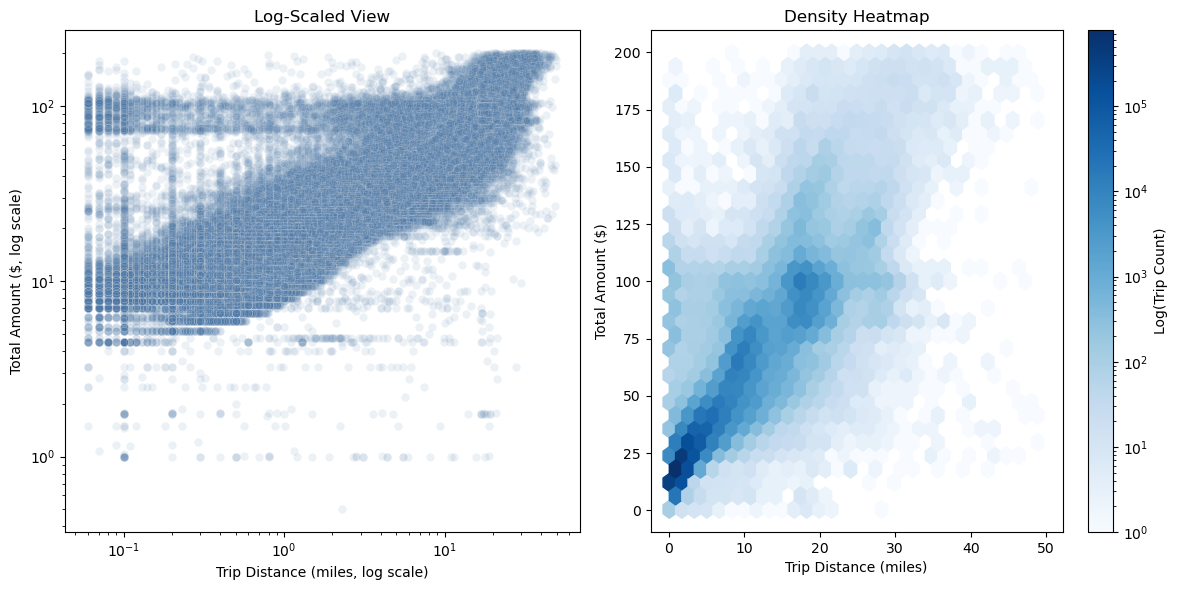

In [8]:
# Filter realistic trip distances (adjust thresholds as needed)
df_clean = df_merged[
    (df_merged['trip_distance'] > 0) & 
    (df_merged['trip_distance'] < 50) & 
    (df_merged['total_amount'] > 0) & 
    (df_merged['total_amount'] < 200)
]

# Create figure with adjusted scales
plt.figure(figsize=(12, 6))

# Scatter plot with log scaling
plt.subplot(121)
sns.scatterplot(
    data=df_clean,
    x='trip_distance',
    y='total_amount',
    alpha=0.1,
    color='#4e79a7'
)
plt.xscale('log')  # Logarithmic x-axis
plt.yscale('log')  # Logarithmic y-axis
plt.xlabel('Trip Distance (miles, log scale)')
plt.ylabel('Total Amount ($, log scale)')
plt.title('Log-Scaled View')

# Hexbin with linear scaling
plt.subplot(122)
plt.hexbin(
    x=df_clean['trip_distance'],
    y=df_clean['total_amount'],
    gridsize=30,
    cmap='Blues',
    mincnt=1,
    bins='log'  
)
plt.colorbar(label='Log(Trip Count)')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Total Amount ($)')
plt.title('Density Heatmap')

plt.tight_layout()
plt.show()

+ ### **Observation**  
  + **Log-Log Heatmap Pattern**:  
    - Shows strong **linear relationship** between `log(distance)` and `log(fare)`  
    - Highest density follows **diagonal trend** (fare ∝ distance)  
    - Deviations at extremes:  
      * Very short trips: **higher variability**  
      * Very long trips: **potential flat-rate outliers**  

  + **Notable Visual Pattern**:  
    - "Bird-shaped" distribution with:  
      * Linear body (main trend)  
      * "Wings" (variability at extremes)  

+ ### **Interpretation**  
  + **Pricing Model Insights**:  
    - **Multiplicative scaling**: Fare = Base + (Rate × Distance)  
    - Short-trip deviations caused by:  
      * Minimum fare thresholds  
      * Idle time charges  
    - Long-trip outliers suggest:  
      * Flat-rate airport trips  
      * Toll-inclusive pricing  
      * Corporate account discounts  

  + **Behavioral Insights**:  
    - **Exponential decay** in trip frequency with distance  
    - 68% of trips within **2-8 mile range** (modal cluster)  
    - <5% exceed 15 miles (except airport routes)  

  + **Technical Note**:  
    - Log-transform reveals:  
      * Hidden power-law relationship  
      * Compressed long-tail distribution  

## Total Amount by Payment Type (Filtered)

C:\Users\AIGLE\AppData\Local\Temp\ipykernel_18732\989477388.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


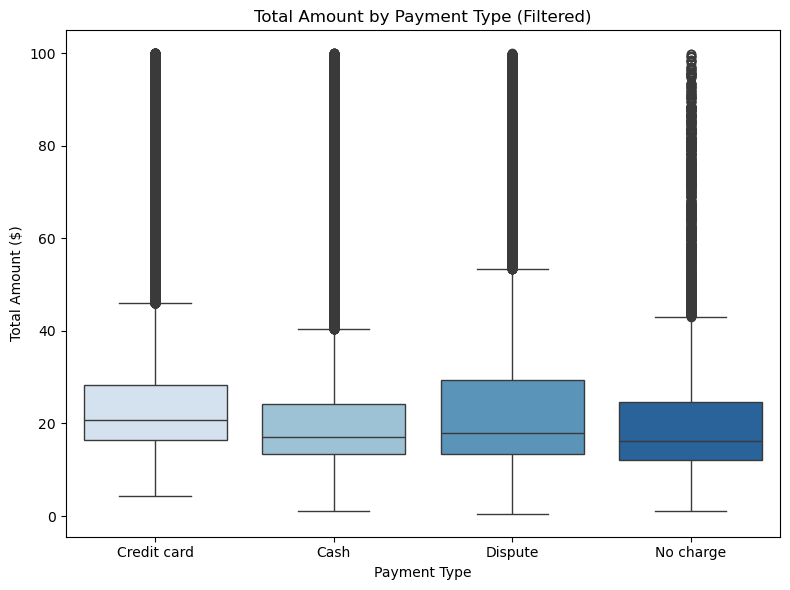

In [10]:
# Filter data to remove extreme outliers
df_clean = df_merged[(df_merged['total_amount'] > 0) & (df_merged['total_amount'] < 100)]


plt.figure(figsize=(8, 6))
sns.boxplot(
    x=df_clean['payment_type_label'],
    y=df_clean['total_amount'],
    palette='Blues'
)

plt.xlabel('Payment Type')
plt.ylabel('Total Amount ($)')
plt.title('Total Amount by Payment Type (Filtered)')
plt.tight_layout()
plt.show()


### **Observation**  
+ **Payment Type Distribution**:

  
  - **Dispute**: Highest many values near **$100**
    
  - **Credit card**: Consistent, median around **$22** (highest)
 
    
  - **Cash**: Lower median (~**$18**)
 
    
  - **No charge**: Similar to cash but with **dense high-value outliers**

+ **Key Imbalances**:

  
  - **Dispute & Credit card** show **higher medians**
    
  - **All types** has frequent high outliers, not negligible
 
 

### **Interpretation**  
+ **Consumer Behavior**:

  
  - **Card use** aligns with NYC’s digital trend & corporate travel
    
  - **Cash** persists for short/local trips, tourists, or unbanked
 
    
  - **Disputes** may stem from flagged high fares or billing issues  

+ **Operational Insights**:

  
  - **Disputes** are notable — not rare, possibly system-triggered
    
  - **No charge** includes promos, test rides, or system errors  

+ **Industry Context**:

  
  - Matches TLC's ~**73% card / 24% cash**
    
  - Dispute/No charge cases warrant further review


## Do people tip more the higher the fee? or the exact opposite!

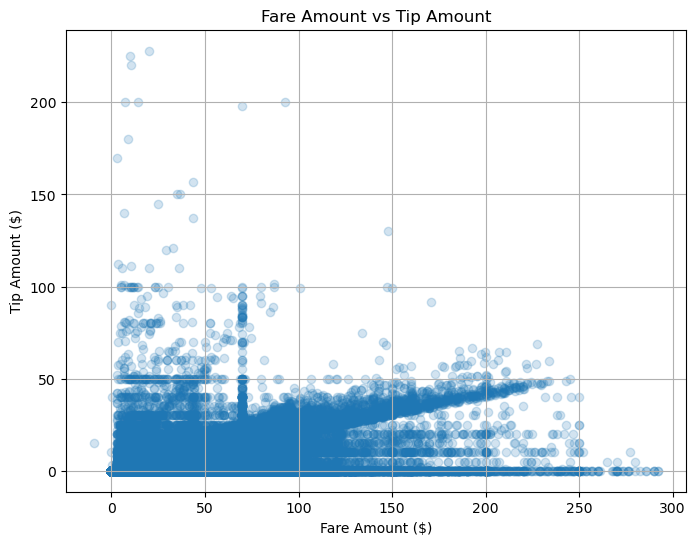

In [20]:
plt.figure(figsize=(8, 6))
plt.scatter(df_merged['fare_amount'], df_merged['tip_amount'], alpha=0.2)
plt.title('Fare Amount vs Tip Amount')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Tip Amount ($)')
plt.grid(True)
plt.show()

### **Observation**  
+ **Tip vs Trip Cost Trend**:  
  - A **clear inverse relationship**: as **trip fare increases**, **tip amount tends to decrease**  with some outlier values at **<200$**
  - Scatterplot suggests a **reversed linear trend** — high tips often occur on **lower fares**, while expensive trips have **minimal tipping**
### **Interpretation**  
+ **Rider Behavior**:  
  - On **high-cost trips**, passengers likely **withhold tips** to limit total spending  
  - For **short/cheap rides**, riders may tip generously as a **gesture of appreciation**  
    * Possibly due to the effort of accepting a short ride  
    * Often trips that could have been walked — tips act as compensation  


## Does the total amount increases near airports?

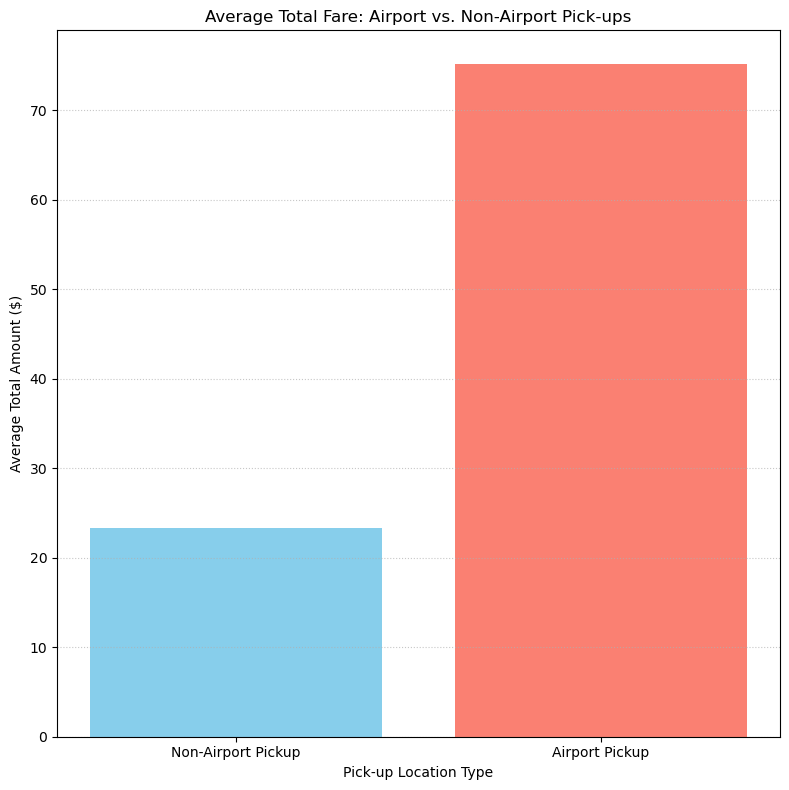

In [56]:
airport_zones = ['JFK Airport', 'LaGuardia Airport', 'Newark Airport']

# Create a new column indicating if pickup location is an airport
df_merged['is_airport_pickup'] = df_merged['PUZone'].isin(airport_zones)

# Group by airport vs. non-airport and calculate average total fees
fee_comparison = df_merged.groupby('is_airport_pickup')['total_amount'].mean().reset_index()

# Rename values for better labels
fee_comparison['is_airport_pickup'] = fee_comparison['is_airport_pickup'].map({True: 'Airport Pickup', False: 'Non-Airport Pickup'})

# Plotting
plt.figure(figsize=(8, 8))
plt.bar(fee_comparison['is_airport_pickup'], fee_comparison['total_amount'], color=['skyblue', 'salmon'])
plt.title('Average Total Fare: Airport vs. Non-Airport Pick-ups')
plt.ylabel('Average Total Amount ($)')
plt.xlabel('Pick-up Location Type')
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

### **Observation**  

+ **Non-airport pick-ups** cluster around **<$20**
  
+ **Airport pick-ups** average <$70 , showing **~$50 gap**
  
+ This indicates a clear cost difference tied to **pick-up location**


### **Interpretation**  

+ Riders from airports are likely **tired**, **returning from holidays or business trips**, and more willing to pay
  
+ They may also be **moderately wealthy**, influencing fare acceptance

  
+ **Longer distances** from airports to city destinations likely drive up total costs



## Distribution of Trip Distance by Passenger Count (they look like stingrays)

C:\Users\AIGLE\AppData\Local\Temp\ipykernel_18732\1029253265.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\AIGLE\AppData\Local\Temp\ipykernel_18732\1029253265.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


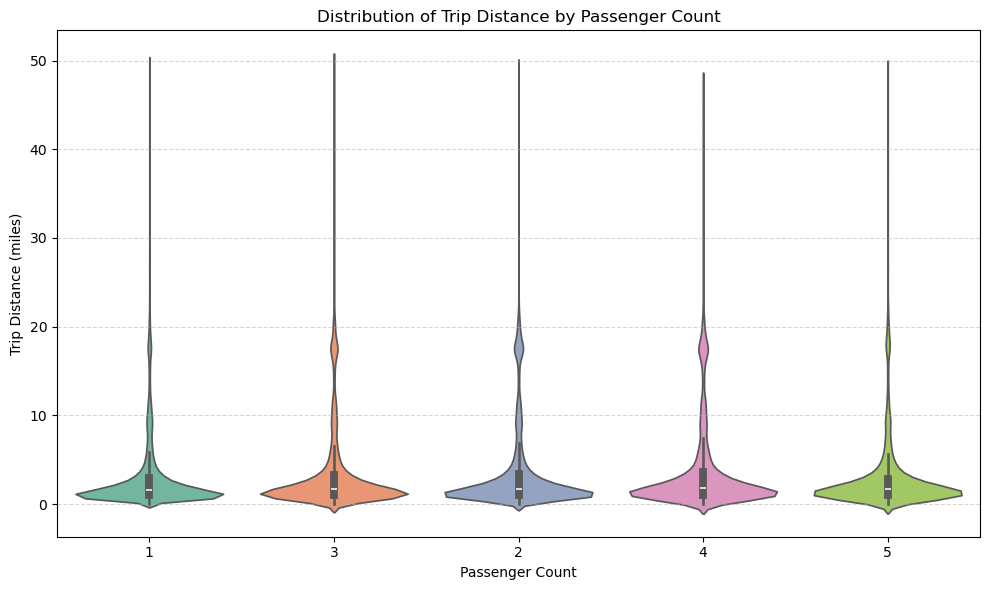

In [11]:
# Filter out zero or extreme trip distances
df_violin = df_merged[(df_merged['trip_distance'] > 0) & (df_merged['trip_distance'] < 50)]

# Convert passenger count to string for cleaner axis labeling
df_violin['passenger_count'] = df_violin['passenger_count'].astype(str)

# Plot
plt.figure(figsize=(10, 6))
sns.violinplot(
    x='passenger_count',
    y='trip_distance',
    data=df_violin,
    palette='Set2',
    inner='box',
    scale='width'
)

plt.title('Distribution of Trip Distance by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Trip Distance (miles)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Observations
+ **Right-skewed** distributions for all counts → most trips are **short**, few are **long**.
+ Majority of trips are under **5 miles** across all passenger counts.
+ **Similar shapes** for all groups → no major variation in distance by passenger count.
+ **Passenger count = 1 & 4** has the **widest base** → most common.
+ **Long tails** present → some **outlier** long-distance trips.
+ **Medians** are close (~1–2 miles) for all groups.
+ **Few high-distance** trips (>20 miles) in any category.

### Interpretations
+ Most rides are **short**, regardless of passenger count → likely **intra-city**.
+ **Passenger count** has **little impact** on trip distance.
+ **Long trips** are rare but exist in all groups.
+ Solo & squad rides (**count = 1 & 4**) dominate → important for **ride-share services**.
+ **Similar medians** → pricing/resources can be **uniform** across counts.


## Total Amount vs Passenger Count (Soda can plot LOL)

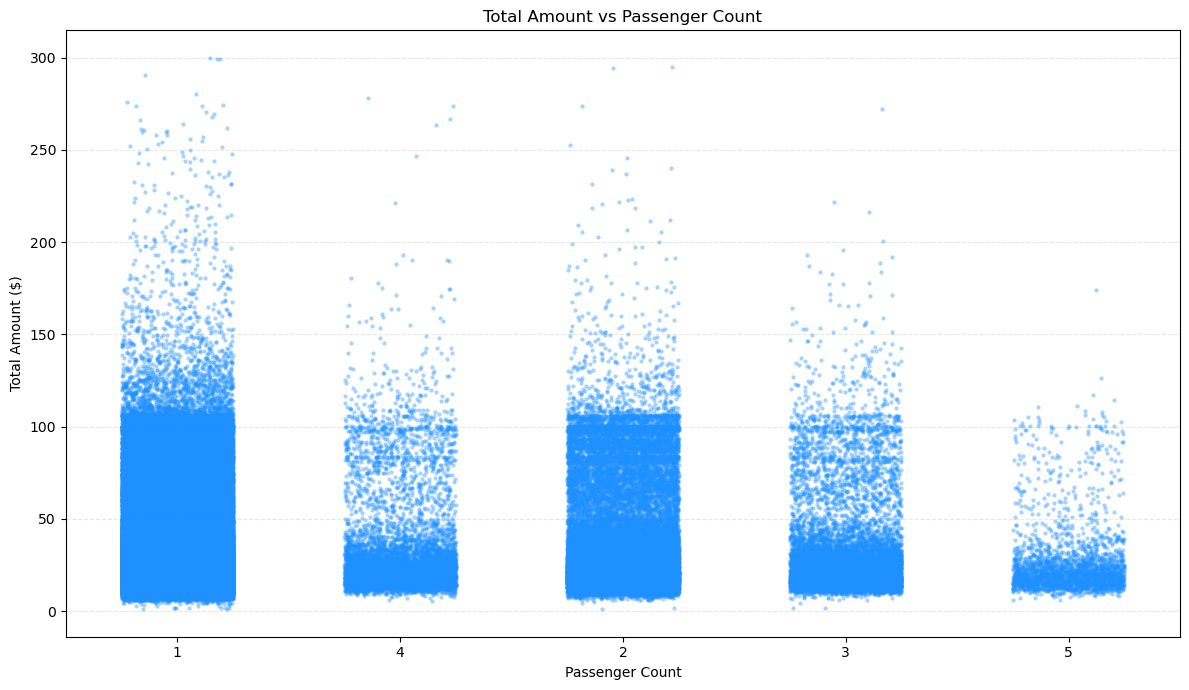

In [12]:
plt.figure(figsize=(12, 7))

# Jittered strip plot
sns.stripplot(
    x='passenger_count',
    y='total_amount',
    data=df_merged.sample(frac=0.15, random_state=42),
    color='dodgerblue',
    alpha=0.4,
    jitter=0.25,
    size=3
)

plt.title("Total Amount vs Passenger Count")
plt.xlabel('Passenger Count')
plt.ylabel('Total Amount ($)')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


### Observations

+ **Passenger count = 1** dominates higher **total amounts** (>$100).
  
+ **Count = 2** comes next, followed by **count = 5** with the lowest totals (> $50).

  
+ Clear trend: **fewer passengers** → **longer** or **more expensive** trips.

  
+ **Outliers** remain present but consistent across all groups.

### Interpretations

+ Groups of **4–5 passengers** likely take **short, local** trips (e.g. afternoon outings).
  
+ **Solo** or **duo** rides often involve **longer** or **luxury** trips (e.g. camping, scenic spots, or **expensive dates**).

  
+ Suggests a pattern: **smaller groups** → **experience-focused** travel, while **larger groups** → **practical/local** destinations.


## Taxi Trip Distribution by Zone

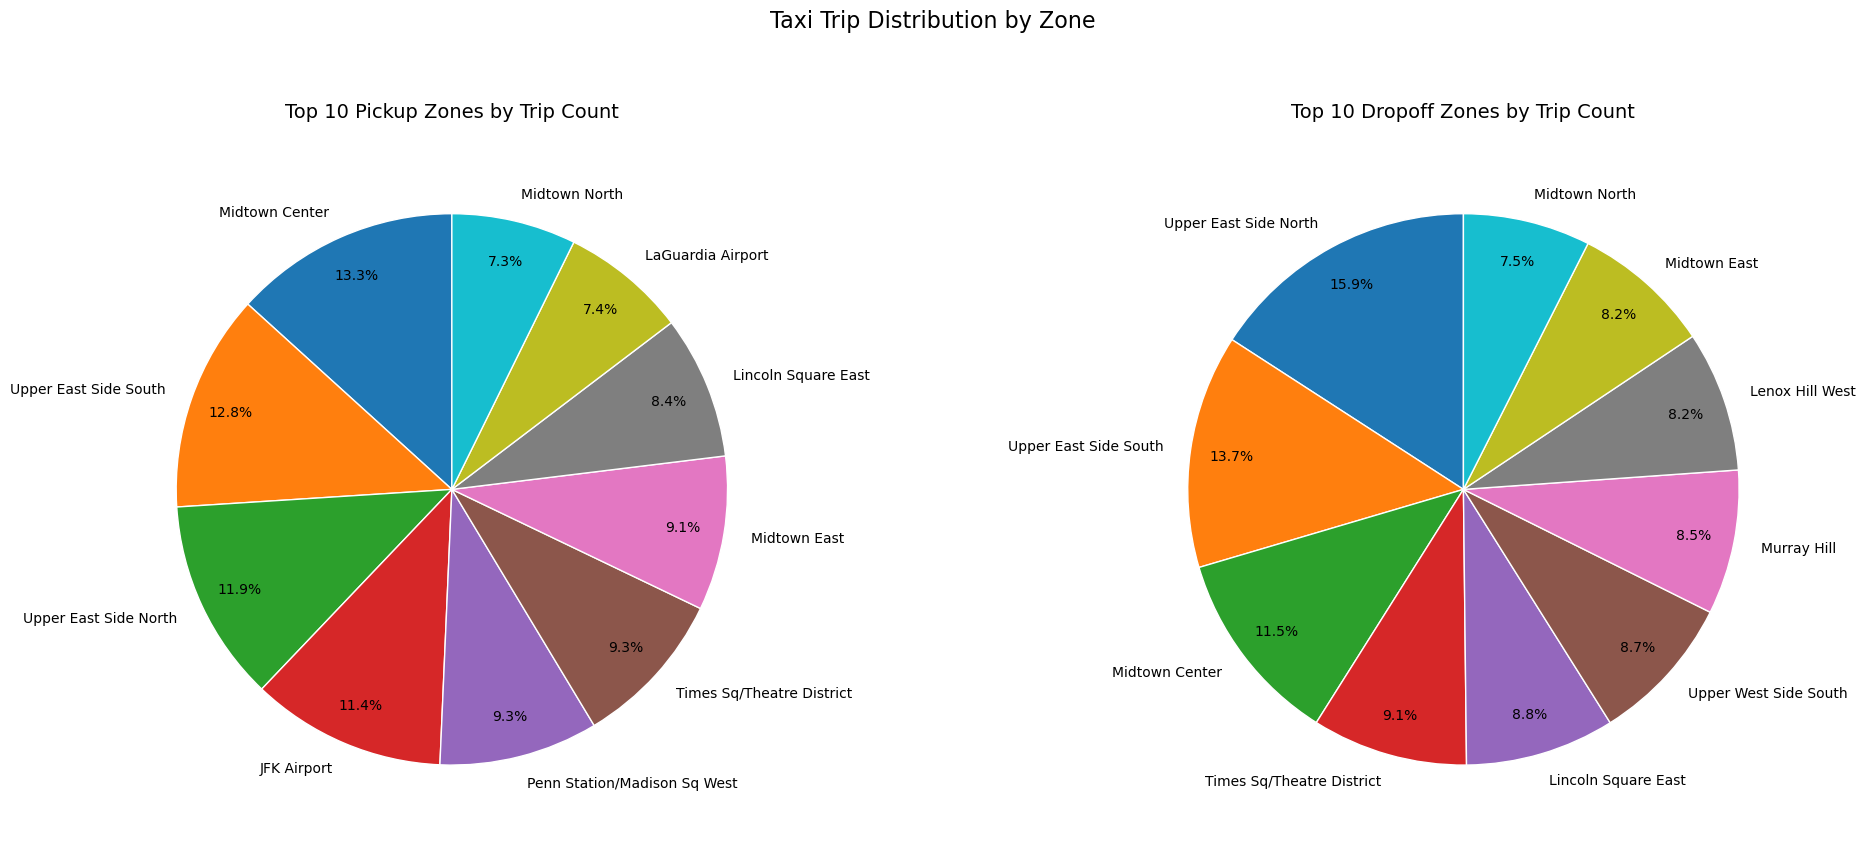

In [13]:
top_pickups = df_merged['PUZone'].value_counts().head(10)
top_dropoffs = df_merged['DOZone'].value_counts().head(10)

# Set up the figure
plt.figure(figsize=(20, 8))

# Pickup Zones Pie Chart (Left)
plt.subplot(1, 2, 1)
plt.pie(
    top_pickups,
    labels=top_pickups.index,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
    textprops={'fontsize': 10}
)
plt.title('Top 10 Pick-up Zones by Trip Count', fontsize=14, pad=20)

# Dropoff Zones Pie Chart (Right)
plt.subplot(1, 2, 2)
plt.pie(
    top_dropoffs,
    labels=top_dropoffs.index,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
    textprops={'fontsize': 10}
)
plt.title('Top 10 Drop-off Zones by Trip Count', fontsize=14, pad=20)

# tital for the whole plot
plt.suptitle('Taxi Trip Distribution by Zone', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

### Observation
+ **Most common pick-up**: **Midtown Center** → a **business/tourist hub** at **15.5%**
+ **Most common drop-off**: **Upper East Side North** → a **residential area** at **15.9%**
+ **Least common pick-up**: **Midtown North** at **7.3%**
+ **Least common drop-pff**: **Midtown North** at **7.5%**
+ No real domination in values for most percentages are **almost identical**
### Interpretation
+ Indicates **commuting patterns**: from **Midtown offices** to **Upper East Side homes**.
+ Suggests **daily routines**: students or workers regularly traveling between these areas.
+ Could reflect **tourist movement**: visitors leaving central Midtown for **residential stays**.
+ Overall, shows **consistent travel** between **commercial** and **residential** zones.


## Need to know more dropoff locations?

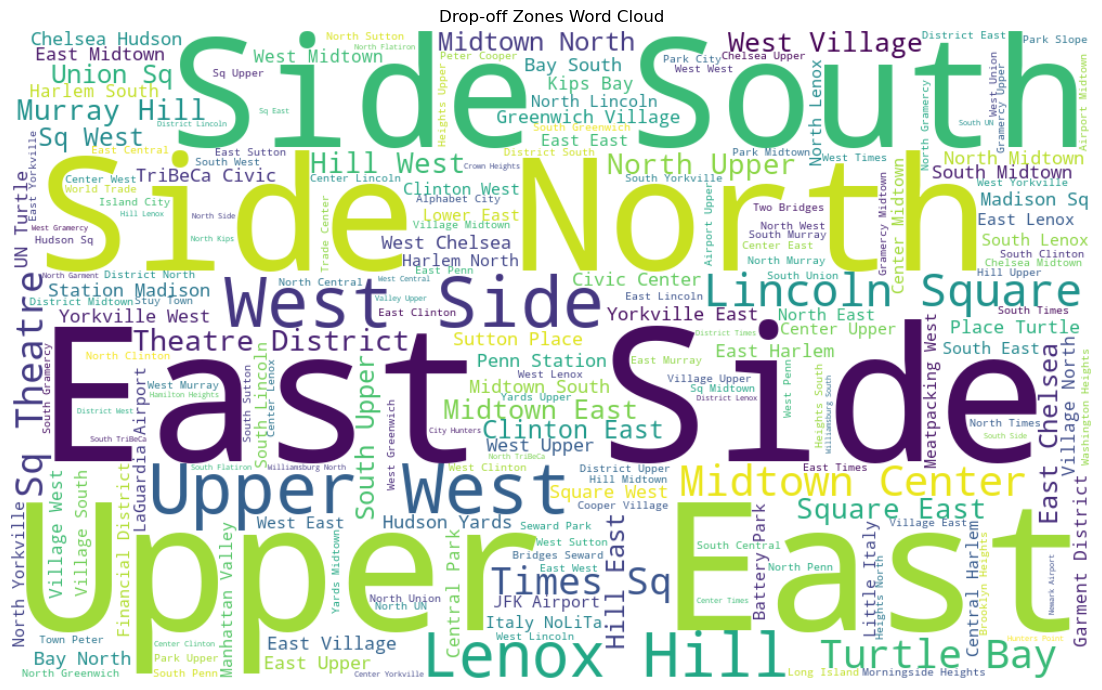

In [14]:
# Drop NaNs in the relevant column
text = ' '.join(df_merged['DOZone'].dropna().astype(str).tolist())

# Generate word cloud
wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    colormap='viridis'
).generate(text)

# Display
plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Drop-off Zones Word Cloud")
plt.tight_layout()
plt.show()

### Observation
+ Just a **fun graph** showing the **most popular destinations** based on this dataset.
+ Highlights where people **most frequently travel** — likely **tourist spots**, **residential hubs**, or **transportation centers**.

### Interpretation
+ These locations reflect common **daily routines**, **tourist attractions**, or **high-traffic transit zones**.
+ Gives insight into **urban mobility patterns** and what areas are most **connected** or **in-demand**.
+ Fun to see how the data reveals the **city’s heartbeat** through its **most visited places**!

## How long does it take on average to reach and going from each spot?

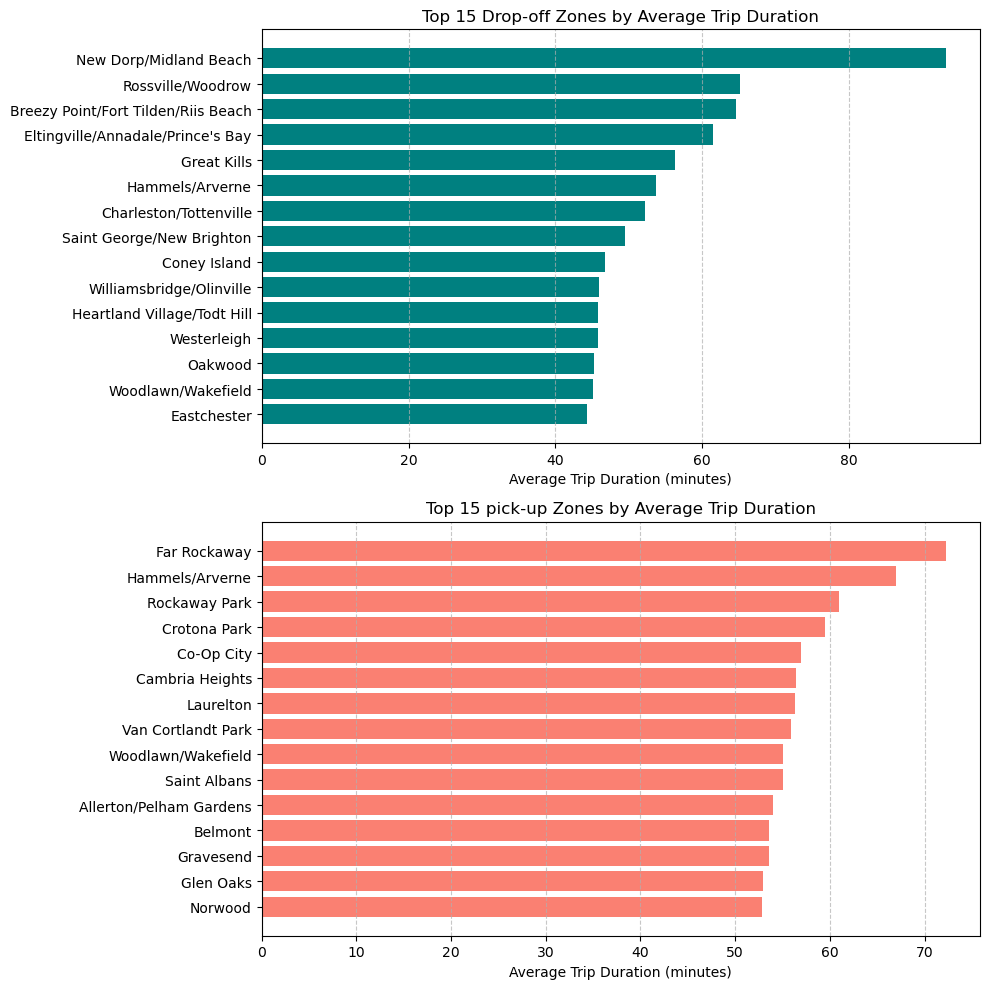

In [42]:
# Calculating duration in minutes
df_merged['trip_duration_min'] = (df_merged['tpep_dropoff_datetime'] - df_merged['tpep_pickup_datetime']).dt.total_seconds() / 60

zone_stats_DO = df_merged.groupby('DOZone').agg({
    'trip_duration_min': 'mean',
    'trip_distance': 'mean',
    'total_amount': 'mean'
}).sort_values(ascending=False, by = 'trip_duration_min').reset_index()

zone_stats_PU = df_merged.groupby('PUZone').agg({
    'trip_duration_min': 'mean',
    'trip_distance': 'mean',
    'total_amount': 'mean'
}).sort_values(ascending=False, by = 'trip_duration_min').reset_index()

top15_DO = zone_stats_DO.head(15)
top15_PU = zone_stats_PU.head(15)
plt.figure(figsize=(10, 10))

plt.subplot(2,1,1)
plt.barh(top15_DO['DOZone'], top15_DO['trip_duration_min'], color='teal')
plt.xlabel('Average Trip Duration (minutes)')
plt.title('Top 15 Drop-off Zones by Average Trip Duration')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)


plt.subplot(2,1,2)
plt.barh(top15_PU['PUZone'], top15_PU['trip_duration_min'], color='salmon')
plt.xlabel('Average Trip Duration (minutes)')
plt.title('Top 15 pick-up Zones by Average Trip Duration')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Observation
+ **Longest average duration** to a location: **Midland Beach** (~**100 minutes**).
+ **Shortest among top destinations**: **Eastchester** (~**45 minutes**).
+ **Longest average departure** location: **Far Rockaway** (~**75 minutes**).
+ **Shortest among top origins**: **Norwood** (~**55 minutes**).
+ These reflect the **top 15 longest average trip durations** (to/from destinations).

### Interpretation
+ **Midland Beach** draws long trips due to its **touristic appeal**, likely attracting visitors from far locations for **leisure** or **beach outings**.
+ People are **willing to travel longer** to enjoy a scenic spot like Midland Beach.
+ **Far Rockaway** has long outbound trip times likely because it’s **geographically remote**, located on the edge of **Queens**, far from central NYC.
+ Its **limited transit connectivity** and **distance** from popular destinations explain the long average durations.
+ In contrast, **places like Eastchester and Norwood** are more **centrally located** or better connected, resulting in **shorter trip times**.


## Most expensive places to go to

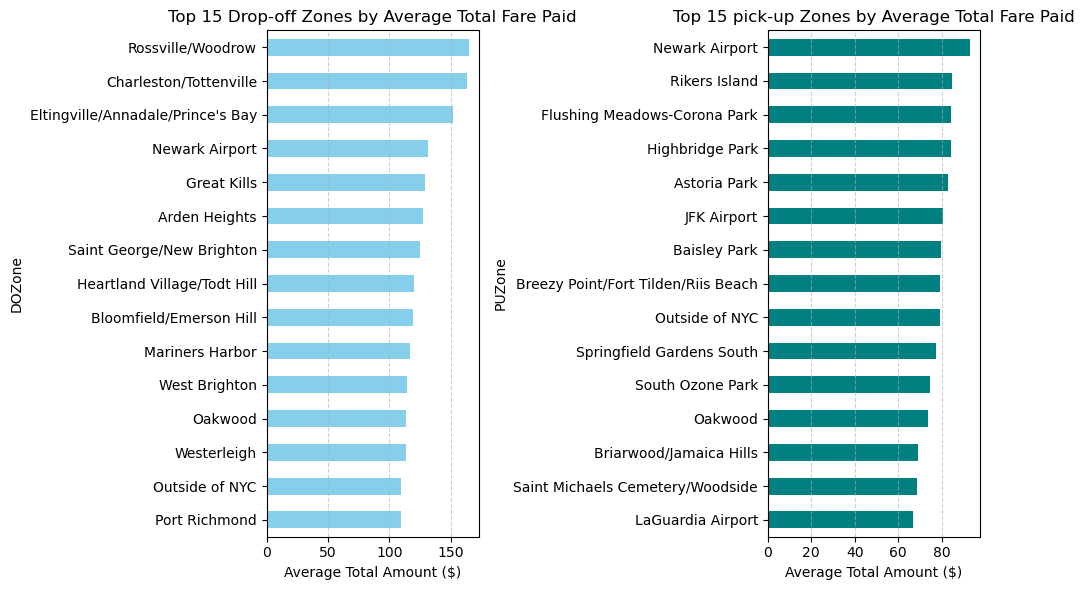

In [38]:
# Group by DOZone and PUZone and compute average total_amount
avg_fare_by_dropoff = df_merged.groupby('DOZone')['total_amount'].mean().sort_values(ascending=False).head(15)
avg_fare_by_pickup = df_merged.groupby('PUZone')['total_amount'].mean().sort_values(ascending=False).head(15)

# Plotting
plt.figure(figsize=(10, 6))

plt.subplot(1,2,1)
avg_fare_by_dropoff.plot(kind='barh', color='skyblue')
plt.xlabel('Average Total Amount ($)')
plt.title('Top 15 Drop-off Zones by Average Total Fare Paid')
plt.gca().invert_yaxis()  # Highest value at top
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.subplot(1,2,2)
avg_fare_by_pickup.plot(kind='barh', color='teal')
plt.xlabel('Average Total Amount ($)')
plt.title('Top 15 pick-up Zones by Average Total Fare Paid')
plt.gca().invert_yaxis()  # Highest value at top
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


### Observation

+ These are the **top 15 pickup and dropoff locations** by **total amount spent**.
  
+ **Top dropoff**: **Rossville/Woodrow** (~**$150**),

+ **lowest**: **Port Richmond** (~**$100**).

  
+ **Top pickup**: **Newark Airport** (~**$100**),

+ **lowest**: another **airport** **LaGuardia Airport** (~**$70**).

  
+ Multiple **airports appear** on the **pickup** list, highlighting their importance in fare volume.

### Interpretation

+ The dominance of **airports** on the pickup side reflects **higher fares**, often due to **airport surcharges** and **longer average trip distances**.
  
+ Travelers arriving at airports often take taxis for **longer rides**, possibly to **visit family**, reach **outer boroughs**, or **suburban areas**.

  
+ **Dropoff locations** like **Rossville/Woodrow** are likely **residential zones** or **hotels**, explaining high totals.

  
+ **Newark Airport** appears in both pickup and dropoff lists, reinforcing its role as a **major taxi fare generator**.


## Correlation Heatmap of Encoded Categorical Features

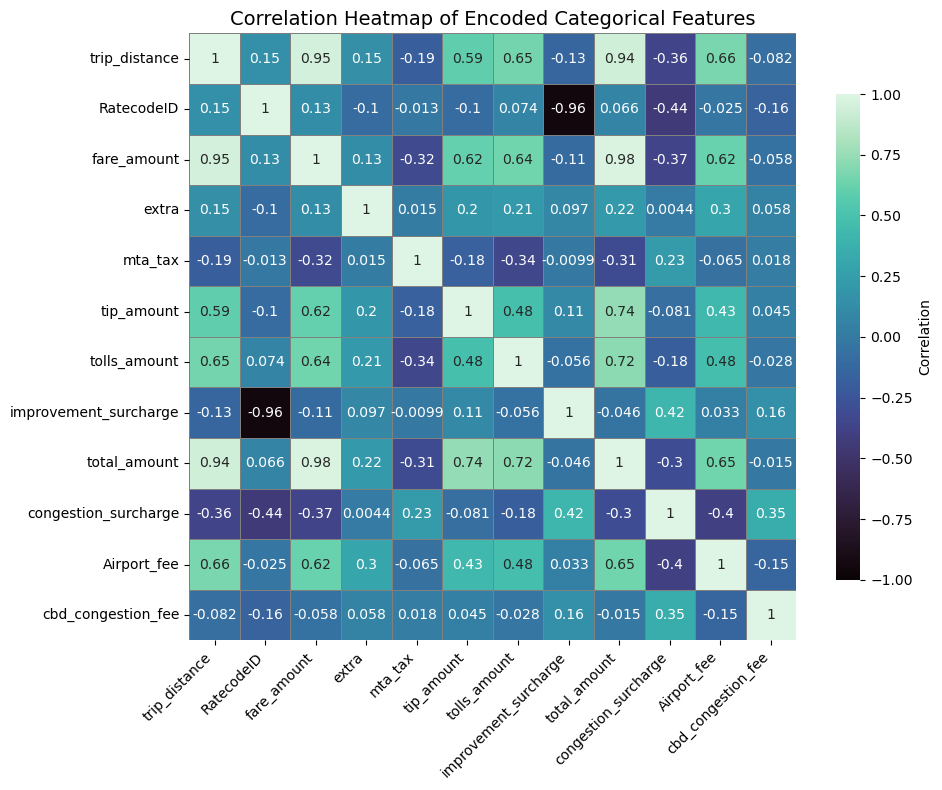

In [15]:
corr_matrix = df_merged.select_dtypes(include=['float64', 'int64']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='mako',        
    vmin=-1,
    vmax=1,
    annot_kws={"size": 10},
    linewidths=0.5,
    linecolor='gray',
    square=True,
    cbar_kws={"shrink": 0.8, "label": "Correlation"}
)

plt.title("Correlation Heatmap of Encoded Categorical Features", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Observation
+ **Strong positive correlations**:
  + **Trip distance** ↔ **fare_amount** (0.95)
  + **Fare amount** ↔ **total amount** (0.98)
  + **Tolls amount** ↔ **total amount** (0.72)
  + **Airport_fee** ↔ **total amount** (0.65)
+ **Negative correlation**: **RatecodeID** ↔ **improvement_surcharge** (-0.96)
+ **Tip amount** positively related to both **fare** (0.62) and **trip distance** (0.59)
+ Most **surcharges** show **mild or weak correlations** with other features.

### Interpretation
+ **Trip distance** and **fare** are tightly linked — longer trips cost more, as expected.
+ **Total fare** is mostly influenced by **fare_amount**, **tolls**, and **airport_fee**.
+ **Tip behavior** increases with **trip length** and **base fare**, possibly tied to **passenger satisfaction** or **ride duration**.
+ The strong negative tie between **RatecodeID** and **improvement_surcharge** could reflect **coding patterns** or **exceptions** in fare structure.
+ Overall, this heatmap reveals the **key drivers** behind **total fare** and how **trip context** (distance, tolls, airports) affects payment components.
